# Загрузка данных и библиотек

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats import proportion
import itertools

In [2]:
data = pd.read_csv("credit_card_default_analysis.csv", index_col="ID")
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(24)
memory usage: 5.7 MB


В данных нет пропусков

In [4]:
data.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

Данные достаточно сильно несбалансированы по целевой переменной - ситуаций дефолта примерно 3-4 раза меньше.

# Задача 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 

1. О равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
2. О равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Значимы ли полученные результаты с практической точки зрения ?

### Предварительный анализ данных

In [5]:
limit_bal_non_default = data.LIMIT_BAL[data.default == 0]
limit_bal_default = data.LIMIT_BAL[data.default == 1]

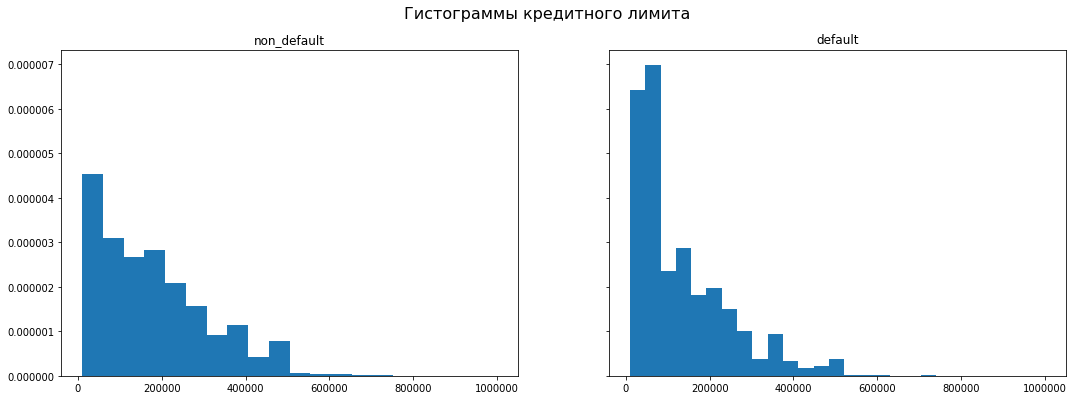

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(18, 6))
fig.suptitle("Гистограммы кредитного лимита", fontsize=16)

ax1.hist(limit_bal_non_default, bins=20, density=True)
ax1.set_title("non_default")
ax2.hist(limit_bal_default, bins=20, density=True)
ax2.set_title("default")
pass

**Выводы:** Группа кредиторов, которые совершили дефолт, имеет значительно более высокую долю низких кредитных лимитов. Сами распределения далеки от нормальных и имеют сильный скос вправо, поэтому параметрические методы, базирующиеся на допущение о нормальности могут работать некорректно - предпочтение стоит отдать непараметрическим методам сравнения несвязанных выборок.

### Проверка гипотезы о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

Учитывая сильную ассиметричность предлагается осуществиь проверку с помощью бутстрепа:

1. Может быть применен для двух несвязанных выборок $X_{1}$ и $X_{2}$
2. $H_{0}$: $medX_{1} = medX_{2}$
3. $H_{1}$: $medX_{1} <> medX_{2}$

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
np.random.seed(0)
med_limit_bal_non_default = np.median(get_bootstrap_samples(limit_bal_non_default.values, 1000), axis=1)
med_limit_bal_default = np.median(get_bootstrap_samples(limit_bal_default.values, 1000), axis=1)

In [10]:
stat_intervals(med_limit_bal_non_default - med_limit_bal_default, 0.05)

array([60000., 70000.])

Различие медиан существенно со статистической точки зрения (pvalue < 0.05) и с практичекой точки зрения, так как сопостовима со средней зарпалатой в Москве и в два раза больше средней зарплаты в России в целом.

### Проверка гипотезы о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Воспользуемся критерием Манна-Уитни:

1. Применяется для двух несвязанных выборок $X_{1}$ и $X_{2}$
2. $H_{0}$: $F_{X_{1}}(x) = F_{X_{2}}(x)$
3. $H_{1}$: $F_{X_{1}}(x) = F_{X_{2}}(x+\Delta), \Delta<>0$ 

In [11]:
stats.mannwhitneyu(limit_bal_non_default, limit_bal_default, alternative="two-sided")

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Гипотеза отвергается с большим запасом по pvalue.

In [12]:
m_limit_bal_non_default = limit_bal_non_default.mean()
m_limit_bal_default = limit_bal_default.mean()
1 - m_limit_bal_default / m_limit_bal_non_default

0.2694561676908547

С практичекой точки зрения различие достаточно значительное, так как позволяет снизить потери в случае дефолта на 27% за счет меньших кредитных лимитов.

### Значимы ли полученные результаты с практической точки зрения ?

Для гипотезы о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки - различие существенное с практической и статистической точки зрения. 

Для гипотезы о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних - различие существенное с практической и статистической точки зрения.

# Задача 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

### Предварительный анализ данных

In [13]:
sex_non_default = data.SEX[data.default == 0]
sex_default = data.SEX[data.default == 1]

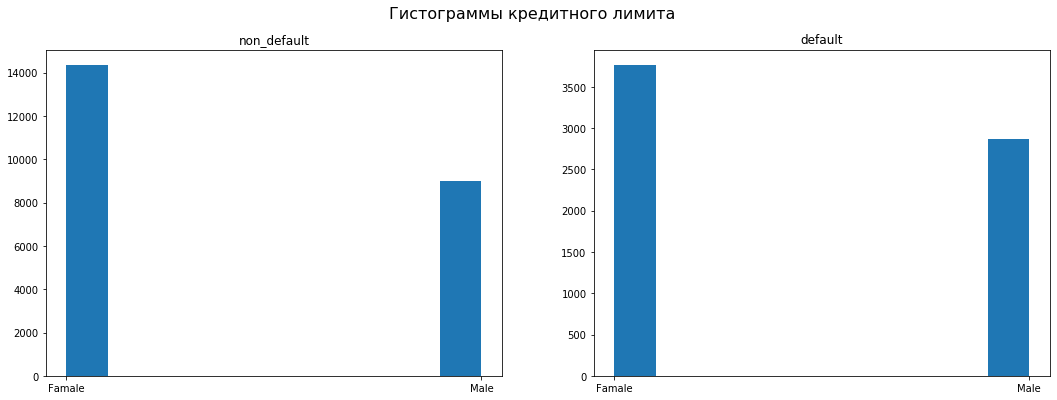

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.suptitle("Гистограммы кредитного лимита", fontsize=16)

ax1.hist(sex_non_default.replace({1: "Male", 2: "Famale"}))
ax1.set_title("non_default")
ax2.hist(sex_default.replace({1: "Male", 2: "Famale"}))
ax2.set_title("default")
pass

**Выводы:** Доля мужчин среди заемщиков, объявивших дефол, визуально выше.

### Проверка гипотезы о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается - вариант 1

Проверим независимость ($H_{0}$) гендерной структуры от отстуствия/наличия дефолта с помощью таблицы сопряженности против альтернативной гипотизы ($H_{1}$) наличия зависимости:

In [15]:
stats.chi2_contingency(
    [[sum(sex_non_default == 2), sum(sex_non_default == 1)], 
     [sum(sex_default == 2), sum(sex_default == 1)]]
)[1]

4.944678999412026e-12

Гипотиза об отсуствии зависимости отвергается pvalue существенно меньшим 0.05

### Проверка гипотезы о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается - вариант 2

Построим доверительные интервалые интервалы для доли женщин в каждой группе. Так как данные бинарные для построения доверительных интервалов можно воспользоваться методом Уилсона:

In [16]:
proportion.proportion_confint(sum(sex_non_default == 2), len(sex_non_default), 0.05, "wilson")

(0.607889734030124, 0.6203726841910749)

In [17]:
proportion.proportion_confint(sum(sex_default == 2), len(sex_default), 0.05, "wilson")

(0.5551017630282817, 0.578937581965066)

Итервалы для pvalue=0.05 не пересекаются, что подверждает большое различие гендерного состава выборок - не потребовалось применять более сильный критерий на разницу долей. Практическую значимость различий сложно оценить не специалисту - различие не такое большое. Окончательный вывод можно сделать на основе более детальной информации о весе данного фактора в общей скоринговой модели и общего объема кредитов. Если банк выдает кредиты на сотни миллионов рублей, сумма потенциальной экономии может быть достаточно существенной для оправдания работы специалистов по анализу данных.

# Задача 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

### Предварительный анализ данных

In [19]:
education_non_default = data.EDUCATION[data.default == 0]
education_default = data.EDUCATION[data.default == 1]

In [20]:
education_non_default = education_non_default.value_counts(sort=False)
education_default = education_default.value_counts(sort=False)
education_comp = pd.concat([education_non_default, education_default], axis=1).fillna(0)
education_comp.columns = ["non_default", "default"]
education_comp.index = [
    "доктор", 
    "магистр", 
    "бакалавр", 
    "выпускник школы", 
    "начальное образование", 
    "прочее", 
    "нет данных"
]
education_comp

,non_default,default
доктор,14,0.0
магистр,8549,2036.0
бакалавр,10700,3330.0
выпускник школы,3680,1237.0
начальное образование,116,7.0
прочее,262,18.0
нет данных,43,8.0


Изначальные данные имеют существенно разное количество случаев в каждой категории по уровню образования. Для лучшей интерпретируемости и приведения к одному масштабу расчитаем условную вероятность дефолта для каждой категории. Доплним данные расчетом общего количества человек в каждой категории.

                       Вероятность дефолта  Количество человек всего
доктор                            0.000000                        14
магистр                           0.192348                     10585
бакалавр                          0.237349                     14030
выпускник школы                   0.251576                      4917
начальное образование             0.056911                       123
прочее                            0.064286                       280
нет данных                        0.156863                        51


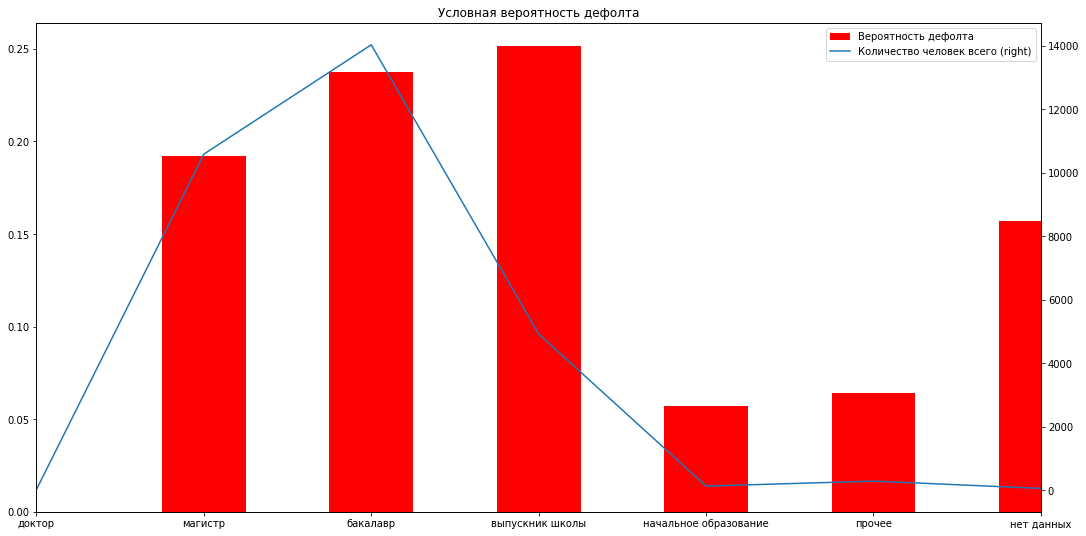

In [21]:
prob_education = education_comp.div(education_comp.sum(axis=1), axis=0)
prob_education = prob_education.default
prob_education.name = "Вероятность дефолта"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
prob_education.plot(ax=ax, color="r", kind="bar", title="Условная вероятность дефолта", legend=True)
amount = education_comp.sum(axis=1).astype(int)
amount.name = "Количество человек всего"
amount.plot(ax=ax, secondary_y=True, legend=True)
print(pd.concat([prob_education, amount], axis=1))
pass

### Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? наоборт, не отдаст долг ?

Вероятность дефолта минимальна для докторов - равна нулю, но общее их количество незначительно. Низкая вероятность дефолта также наблюдается у людей с начальным образованием и категорий прочее. Количество таких случаев так же не велико, но уже исчисляется сотнями. 

Вероятность дефолта максимальная для выпускников школ - достаточно многочисленная категория.

### Проверка гипотезы о том, что образование не влияет на то, вернет ли человек долг

Проверим формально независимость ($H_{0}$) уровня образования от отстуствия/наличия дефолта с помощью таблицы сопряженности против альтернативной гипотизы ($H_{1}$) наличия зависимости:

In [22]:
stats.chi2_contingency(education_comp)[1]

1.2332626245415605e-32

Гипотиза об отсуствии влияния образования на вероятность дефолта отвергается - pvalue существенно меньшим 0.05.

Учитывая, что условные вероятности варьируются на десятки процентов в зависимости от категории образования, данный фактор достаточно существеннен.

# Задача 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

### Предварительный анализ данных

In [24]:
marriage_non_default = data.MARRIAGE[data.default == 0]
marriage_default = data.MARRIAGE[data.default == 1]

In [25]:
marriage_non_default = marriage_non_default.value_counts(sort=False)
marriage_default = marriage_default.value_counts(sort=False)
marriage_comp = pd.concat([marriage_non_default, marriage_default], axis=1).fillna(0)
marriage_comp.columns = ["non_default", "default"]
marriage_comp.index = [
    "отказываюсь отвечать", 
    "замужем/женат", 
    "холост", 
    "нет данных", 
]
marriage_comp

,non_default,default
отказываюсь отвечать,49,5
замужем/женат,10453,3206
холост,12623,3341
нет данных,239,84


По аналогии с предыдущим заданием предлагается посчитать условные вероятности дефолта для каждого варианта семейного статуса.

                      Вероятность дефолта  Количество человек всего
отказываюсь отвечать             0.092593                        54
замужем/женат                    0.234717                     13659
холост                           0.209283                     15964
нет данных                       0.260062                       323


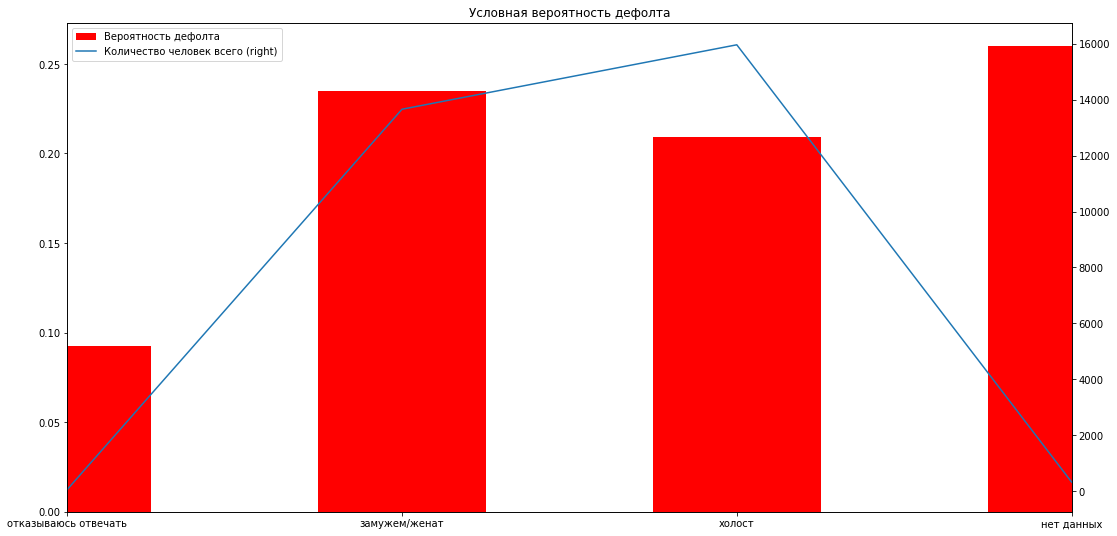

In [26]:
prob_marriage = marriage_comp.div(marriage_comp.sum(axis=1), axis=0)
prob_marriage = prob_marriage.default
prob_marriage.name = "Вероятность дефолта"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
prob_marriage.plot(ax=ax, color="r", kind="bar", title="Условная вероятность дефолта", legend=True)
amount = marriage_comp.sum(axis=1).astype(int)
amount.name = "Количество человек всего"
amount.plot(ax=ax, secondary_y=True, legend=True)
print(pd.concat([prob_marriage, amount], axis=1))
pass

**Выводы:** Холостые имеют несколько меньшую вероятность дефолта, чем замужние/женатые. Минимальная вероятность дефолта для отказывающихся отвечать, но она крайне малачислена.

### Мера, по которой можно измерить возможную связь этих переменных и посчитать ее значение

Проверим формально независимость ($H_{0}$) семеного статуса от отстуствия/наличия дефолта с помощью таблицы сопряженности против альтернативной гипотизы ($H_{1}$) наличия зависимости вычислим $\chi^2$:

In [27]:
marriage_comp.sum().sum()

30000

In [28]:
chi2, pvalue, *_ = stats.chi2_contingency(marriage_comp)
chi2, pvalue

(35.66239583433609, 8.825862457577375e-08)

Гипотиза об отсуствии влияния семеного статуса на вероятность дефолта отвергается - pvalue существенно меньшим 0.05.

Учитывая, что условные вероятности варьируются существенно только для очень не значительной категории (отказываюсь отвечать), выводы о практической значимости сделать сложно без дополнительных данных о скоринговой модели.

Силу взаимосвязи дополнительно можно оценить с помощью V Крамера.

In [29]:
(chi2 / (marriage_comp.sum().sum() * (min(marriage_comp.shape) - 1))) ** 0.5

0.034478203662766466

Значение V Крамера близко к 0, что свидетельствует о слабой взаимосвязи.

# Задача 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

### Предварительный анализ данных

In [30]:
age_non_default = data.AGE[data.default == 0]
age_default = data.AGE[data.default == 1]

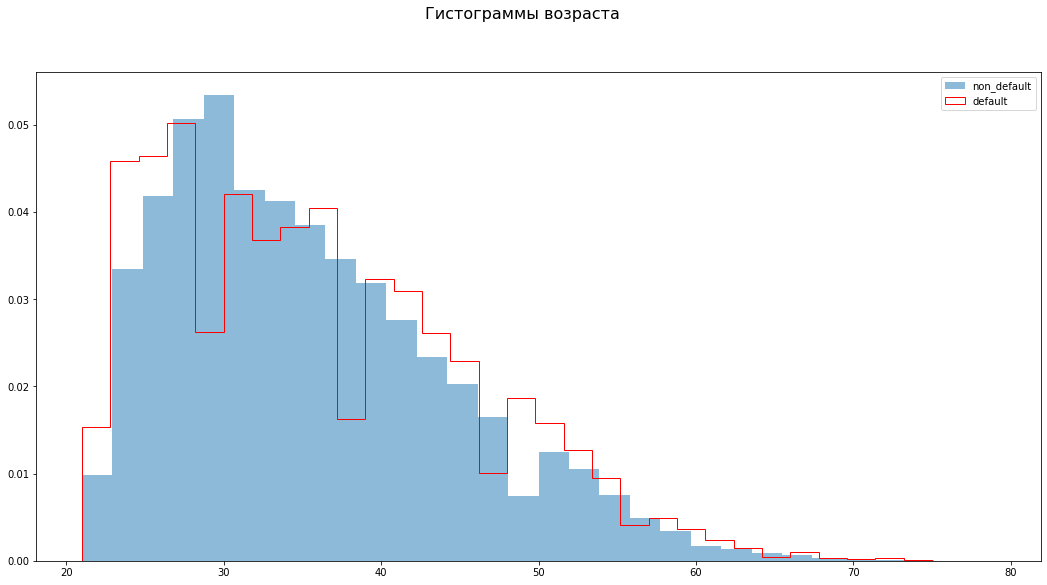

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 9))
fig.suptitle("Гистограммы возраста", fontsize=16)

ax.hist(age_non_default, bins=30, alpha=0.5, density=True, label="non_default")
ax.hist(age_default, bins=30, color="r", histtype="step", density=True, label="default")
ax.legend()
pass

**Выводы:** Распределения по возрастам для обоих категорий достаточно близки, но у имеющих дефолт наблюдается "гребенка" в виде трех провалов. Сложно сказать, чем это вызвано - возможно существенно меньшим количеством данных для этой группы.  

### Проверка гипотезы о равенстве медианных значений возрастов людей

Учитывая сильную ассиметричность предлагается осуществиь проверку с помощью бутстрепа:

1. Может быть применен для двух несвязанных выборок $X_{1}$ и $X_{2}$
2. $H_{0}$: $medX_{1} = medX_{2}$
3. $H_{1}$: $medX_{1} <> medX_{2}$

In [32]:
np.random.seed(0)
med_age_non_default = np.median(get_bootstrap_samples(age_non_default.values, 10000), axis=1)
med_age_default = np.median(get_bootstrap_samples(age_default.values, 10000), axis=1)

In [33]:
med_age_non_default.mean(), med_age_default.mean()

(33.9997, 34.0993)

In [34]:
stat_intervals(med_age_non_default - med_age_default, 0.01)

array([-1.,  0.])

Различие медиан не существенно со статистической точки зрения (pvalue < 0.01), а значение близко к 34 годам в обеих группах.

### Проверка гипотезы о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

Воспользуемся критерием Манна-Уитни:

1. Применяется для двух несвязанных выборок $X_{1}$ и $X_{2}$
2. $H_{0}$: $F_{X_{1}}(x) = F_{X_{2}}(x)$
3. $H_{1}$: $F_{X_{1}}(x) = F_{X_{2}}(x+\Delta), \Delta<>0$ 

In [35]:
stats.mannwhitneyu(med_age_non_default, med_age_default, alternative="two-sided")

MannwhitneyuResult(statistic=44916521.0, pvalue=7.84014398413224e-235)

Гипотеза отвергается с большим запасом по pvalue.

### Значимы ли полученные результаты с практической точки зрения ?

Учитывая, что различие медиан статистически незначимо, величина медианы врядли имеет и практический смысл, так как решения принимаются для конкретного человека.

Хотя различие распределения статистически значимо различаются, практическую значимость этого факта оценить достаточно сложно. Нельзя исключать, что возраст в сочетании с другими факторами, может выступать важным пресказательным фактором, но для таких выводов нужно иметь больше информации о модели скоринга.